# Introduction

In [ ]:
# Import built-in Python libraries
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import gridspec

import tensorflow as tf
import numpy as np
import scipy.io.wavfile
import librosa
import glob
import os
import pickle
import time
import datetime
import importlib

In [ ]:
# Path variables
drive_path = "/content/drive/My Drive/KInsekten/"

data_path         = drive_path + "data/Potatamis/"
figures_path      = drive_path + "figures/"
scripts_path      = drive_path + "scripts/"
pot_models_path   = drive_path + "models/Potatamis/"
keogh_models_path = drive_path + "models/Keogh/"

# Plot font sizes
title_size = 32
label_size = 27
ticks_size = 27
fig_size   = (20, 14)

In [ ]:
strategy = 'CPU' #@param ["CPU", "GPU", "TPU"]

if strategy is 'CPU':
  strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  print('/device:CPU:0')
elif strategy is 'GPU':
  if tf.config.list_physical_devices('GPU'):
    tf.test.gpu_device_name()
    strategy = tf.distribute.MirroredStrategy()
  else:
    print('No GPU detected')
elif strategy is 'TPU':
  try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
  except ValueError:
    print('No TPU detected')

/device:CPU:0


In [ ]:
os.chdir(drive_path)
import wingbeats
from wingbeats.modelling import *
from wingbeats.processing import *
from wingbeats.xai import *

# Load signals

In [ ]:
os.chdir(scripts_path)
#!python Potatamis_Prepare_Environment.py -h # prints usage

# Create folders and copy data from Drive (False = no test signals)
!python Potatamis_Prepare_Environment.py "/content/drive/My Drive/KInsekten/data/Potatamis/" False

Running Potatamis_Prepare_Environment.py
Loading Train and CV.
###################################

Train_amplitudes.zip copied
CV_amplitudes.zip copied
CV_labels.pickle copied
40 seconds

Train unzipped
CV unzipped
75 seconds



Species and Genus encoding

In [ ]:
# Dictionary of genera with the included species
genus_species_dict = {
    'Aedes': ['Ae_aegypti', 'Ae_albopictus'],
    'Anopheles': ['An_arabiensis', 'An_gambiae'],
    'Culex': ['Cu_pipiens', 'Cu_quinquefasciatus']
}

# Store species from the dictionary values (list flattening)
species = [s for l in list(genus_species_dict.values()) for s in l]
print(species)

# Store genus from the keys
genus = list(genus_species_dict.keys())
print(genus)

# Store genus that each species belongs to as a Look-Up Table
genus_mapping = []
for val, gen_ind in zip(genus_species_dict.values(), range(len(genus))):
  genus_mapping += [gen_ind] * len(val)
print(genus_mapping)

['Ae_aegypti', 'Ae_albopictus', 'An_arabiensis', 'An_gambiae', 'Cu_pipiens', 'Cu_quinquefasciatus']
['Aedes', 'Anopheles', 'Culex']
[0, 0, 1, 1, 2, 2]


Class Embeddings

In [ ]:
# Similarity matrix
S = np.identity(len(species))

diag_ind = 0
for gen_ind in range(len(genus)):

  # How many species belong to the current genus index?
  spec_in_gen = genus_mapping.count(gen_ind)
  
  # Each sub-block corresponding to a genus will be filled with 1/2
  # except along the diagonal which has 1's
  for i in range(spec_in_gen):
    for j in range(spec_in_gen):
      if i != j:
        S[diag_ind+i, diag_ind+j] = 1/2

  diag_ind += spec_in_gen
print(S)

[[1.  0.5 0.  0.  0.  0. ]
 [0.5 1.  0.  0.  0.  0. ]
 [0.  0.  1.  0.5 0.  0. ]
 [0.  0.  0.5 1.  0.  0. ]
 [0.  0.  0.  0.  1.  0.5]
 [0.  0.  0.  0.  0.5 1. ]]


In [ ]:
# Compute matrix of embedded vectors from similarity matrix
emb_matrix = np.asarray( unitsphere_embedding(S), dtype = np.float32 )
genus_mapping = np.asarray(genus_mapping)
print(np.round(emb_matrix, 4))

[[1.    0.    0.    0.    0.    0.   ]
 [0.5   0.866 0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.5   0.866 0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.5   0.866]]


Construct data matrix X_train

In [ ]:
# The training set and the validation set are mixed together (they will be later randomly split during KFold)
X_train, y_train, X_cv, y_cv = [], [], [], []
sampling_rate = 8000
len_specs = [] # list of species lengths in Train
max_train = 1500000

print('Loading training set into X_train...')
for i in range(len(species)):
  with open('/content/KInsekten/Potatamis/Train/'+species[i]+'.pickle', 'rb') as f:
    X_spec = pickle.load(f)
    if len(X_spec) > max_train:
      X_spec = X_spec[:max_train]
    for sig in X_spec:
      X_train.append(sig)
    len_spec = len(X_spec)
    y_train += [[genus_mapping[i], i]] * len_spec
    print(species[i] + ': ' + str(len_spec))
    len_specs.append(len_spec)
print('Total: ' + str(len(X_train)))

print('\nLoading validation set into X_cv...')
with open('/content/KInsekten/Potatamis/CV/CV_amplitudes.pickle', 'rb') as f: # signals
  X_cv = pickle.load(f)
  #for sig in X_cv:
  #  X_train.append(sig)

with open('/content/KInsekten/Potatamis/CV/CV_labels.pickle', 'rb') as f: # labels
  y_cv_temp = pickle.load(f)
  for lab in y_cv_temp:
    y_cv.append([genus_mapping[lab], lab])
#print('New total: ' + str(len(X_train)))
print('Total: ' + str(len(X_cv)))

Loading training set into X_train...
Ae_aegypti: 20000
Ae_albopictus: 12138
An_arabiensis: 11577
An_gambiae: 20000
Cu_pipiens: 18249
Cu_quinquefasciatus: 20000
Total: 101964


In [ ]:
# Optional: draw random uniform samples
"""
indices = [0]
for i in range(len(species)):
  indices.append(indices[i] + y_cv_temp.count(i))

X_cv, y_cv = get_uniform_random_samples(X_cv, y_cv, 3000, indices, return_numpy = False)
"""

In [ ]:
# Normalize amplitudes and map them to [-1, 1]
for i in range(len(X_train)):
  X_train[i] = X_train[i] / np.max(np.abs(X_train[i])) 
for i in range(len(X_cv)):
  X_cv[i] = X_cv[i] / np.max(np.abs(X_cv[i])) 

# Data preprocessing

In [ ]:
# Define initial training parameters
epochs = 30
batch_size = 64
drop_rate = 0.5 
format_params = {'psd':     {'window': 'hanning',
                             'in_shape': (129, 1),
                             'noverlap': 192},
                 'spectro': {'window': tf.signal.hann_window,
                             'in_shape': (129, 113, 3),
                             'noverlap': 256-256//6}}
input_formats = list(format_params.keys())

# For Welch-Transform
nperseg  = 256        
cutoff   = None

In [ ]:
# Define dictionary of model constructors, output shapes and hyperparameters
models_dict = {'SimpleCls':    {'constructor': build_simple_classifier, 
                                'out_shape': len(species),
                                'lr_reg': {input_formats[0]: (1e-3, 1e-4),
                                           input_formats[1]: (5e-4, 1e-3)},
                                'loss': 'sparse_categorical_crossentropy',
                                'metrics': ['accuracy']}, 
               
               'SimpleEmbCls': {'constructor': build_simple_embedder_classifier, 
                                'out_shape': [len(species), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-2),
                                           input_formats[1]: (5e-3, 5e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix),
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "species": 'accuracy'}},
               
               'HieraCls':     {'constructor': build_hiera_classifier, 
                                'out_shape': [len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-4, 1e-3),
                                           input_formats[1]: (5e-4, 5e-4)},
                                'loss': {"genus":   'sparse_categorical_crossentropy', 
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"genus": 'accuracy', 
                                            "species": 'accuracy'}},
               
               'HieraEmbCls':  {'constructor': build_hiera_embedder_classifier, 
                                'out_shape': [len(species), len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-3),
                                           input_formats[1]: (5e-3, 1e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix), 
                                         "genus": 'sparse_categorical_crossentropy',
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "genus": 'accuracy', 
                                            "species": 'accuracy'}}
              }

model_names = list(models_dict.keys())

# Train models

**Note**: Different patience times were used for PSD and Spectro:
*   PSD: EarlyStopper 10, ReducePlateau 5
*   Spectro: EarlyStopper 5, ReducePlateau 3

In [ ]:
inp_form = 'spectro'
model_name = model_names[3]
full_name = model_name + '_' + inp_form

print('\n*********** ' + full_name + ' ***********')

window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
noverlap = format_params[inp_form]['noverlap']
weights_file  = keogh_models_path + model_name + '/' + inp_form + '/' + full_name + '_9.h5' # Keogh weights
histories_dir = pot_models_path + model_name + '/' + inp_form + '/histories/' # for figures
frozen_path   = pot_models_path + model_name + '/' + inp_form + '/' + full_name + '_frozen.h5' # save frozen Pot. weights

# Preprocess subsets
# Note: the psd-conversion function changes the array itself, not a copy
# Note: TPU will crash if you attempt to convert the whole training set directly
limit = 50000
X_train_1, y_train_1 = X_train[:limit], y_train[:limit]
X_train_2, y_train_2 = X_train[limit:2*limit], y_train[limit:2*limit]
X_train_3, y_train_3 = X_train[2*limit:], y_train[2*limit:]

train_subset_1 = preprocess_dataset(X_train_1 if inp_form == 'spectro' else list(np.copy(X_train_1)), 
                                    y_train_1, model_name, inp_form, sampling_rate, batch_size,
                                    window, nperseg, noverlap, cutoff, shuffle = False, prefetch = False)
train_subset_2 = preprocess_dataset(X_train_2 if inp_form == 'spectro' else list(np.copy(X_train_2)), 
                                    y_train_2, model_name, inp_form, sampling_rate, batch_size,
                                    window, nperseg, noverlap, cutoff, shuffle = False, prefetch = False)
train_subset_3 = preprocess_dataset(X_train_3 if inp_form == 'spectro' else list(np.copy(X_train_3)), 
                                    y_train_3, model_name, inp_form, sampling_rate, batch_size,
                                    window, nperseg, noverlap, cutoff, shuffle = False, prefetch = False)
train_set = train_subset_1.concatenate(train_subset_2).concatenate(train_subset_3)
train_set = train_set.shuffle(buffer_size = len(X_train), reshuffle_each_iteration = True) 
train_set = train_set.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

cv_set    = preprocess_dataset(X_cv if inp_form == 'spectro' else list(np.copy(X_cv)), 
                               y_cv, model_name, inp_form, sampling_rate, batch_size,
                               window, nperseg, noverlap, cutoff, shuffle = True, cache = False,
                               drop_uneven_batch = True) # embedding_loss is NaN for spectrograms,
                                                         # because of a problem with the last batch apparently

# Roll out models dictionary
constructor = models_dict[model_name]['constructor']
out_shape   = models_dict[model_name]['out_shape']
lr          = models_dict[model_name]['lr_reg'][inp_form][0]
reg         = models_dict[model_name]['lr_reg'][inp_form][1]
loss        = models_dict[model_name]['loss']
metrics     = models_dict[model_name]['metrics']

# Build and compile
cnn_name = 'CNN_Blocks_' + model_name
tf.keras.backend.clear_session() # avoid stacking graphs on one another
with strategy.scope():
    if inp_form == 'psd':
        cnn = CNN1D(drop_rate, name = cnn_name) 
    elif inp_form == 'spectro':
        #cnn = CNN2D(drop_rate, name = cnn_name) 
        cnn = CNN_Mobile(in_shape, 0.25, drop_rate, name = 'CNN_Blocks_mobile')
        #cnn = CNN_Efficient(in_shape, drop_rate, name = 'CNN_Blocks_eff')

    model = constructor(in_shape, out_shape, cnn, reg, 
                        input_name = inp_form, model_name = full_name)
                        #training = False)

    model.load_weights(weights_file, by_name = True, skip_mismatch = True) 

    # Note: if you only want to freeze a part of the CNN, you need to set each targeted conv. block to non-trainable
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    model.compile(tf.keras.optimizers.Adam(lr), loss = loss, metrics = metrics)

# Callbacks
earlyStopper = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3,
                             patience = 5, verbose = 1)
lr_sched = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_delta = 1e-2,
                             min_lr = lr * 0.01, patience = 3, verbose = 1)
model_callbacks = [earlyStopper, lr_sched]

# Train frozen model
history_frozen = model.fit(train_set, epochs = epochs, validation_data = cv_set, callbacks = model_callbacks)


*********** HieraEmbCls_spectro ***********


Epoch 1/30
2621/2621 [==============================] - 279s 57ms/step - loss: 1.9341 - embedding_loss: 0.3024 - genus_loss: 0.6263 - species_loss: 0.9704 - embedding_similarity: 0.6976 - genus_accuracy: 0.7330 - species_accuracy: 0.6520 - val_loss: 1.2503 - val_embedding_loss: 0.2433 - val_genus_loss: 0.3786 - val_species_loss: 0.5832 - val_embedding_similarity: 0.7567 - val_genus_accuracy: 0.8445 - val_species_accuracy: 0.7819
Epoch 2/30
2621/2621 [==============================] - 270s 55ms/step - loss: 1.3833 - embedding_loss: 0.2468 - genus_loss: 0.4272 - species_loss: 0.6640 - embedding_similarity: 0.7532 - genus_accuracy: 0.8348 - species_accuracy: 0.7683 - val_loss: 1.1235 - val_embedding_loss: 0.2264 - val_genus_loss: 0.3237 - val_species_loss: 0.5285 - val_embedding_similarity: 0.7736 - val_genus_accuracy: 0.8758 - val_species_accuracy: 0.8095
Epoch 3/30
2621/2621 [==============================] - 274s 55ms/step - loss: 1.2561 - embedding_loss: 0.2289 - genus_loss: 0.3799 - 

In [ ]:
# Save frozen model
# Note: we do this, so that after unfreezing we can set the training parameter of Batch_Norm to False
#       If it is not False, the unfrozen training will destroy information learnt in the frozen phase.
model.save_weights(frozen_path)

stop_ep = 22 # last frozen epoch

In [ ]:
# Reload frozen weights
cnn_name = 'CNN_Blocks_' + model_name
tf.keras.backend.clear_session() # avoid stacking graphs on one another
with strategy.scope():
    if inp_form == 'psd':
        cnn = CNN1D(drop_rate, name = cnn_name) 
    elif inp_form == 'spectro':
        cnn = CNN2D(drop_rate, name = cnn_name) 

    model = constructor(in_shape, out_shape, cnn, reg, 
                        input_name = inp_form, model_name = full_name,
                        training = False)

    # Note: the previously frozen layers also need to be refrozen first, in order to successfully load the weights
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.bnorm_0.trainable = False
    cnn_layer.block_1.trainable = False
    cnn_layer.block_2.trainable = False

    model.load_weights(frozen_path, by_name = True, skip_mismatch = True) 

    # Only now can you unfreeze these layers
    cnn_layer.bnorm_0.trainable = True
    cnn_layer.block_1.trainable = True
    cnn_layer.block_2.trainable = True

    model.compile(tf.keras.optimizers.Adam(lr*1e-2), loss = loss, metrics = metrics)

# Train unfrozen model
history_unfrozen = model.fit(train_set, epochs = stop_ep+5, 
                             initial_epoch = stop_ep, 
                             validation_data = cv_set, callbacks = model_callbacks[0])

Epoch 23/27
2621/2621 [==============================] - 298s 62ms/step - loss: 0.6815 - embedding_loss: 0.0974 - genus_loss: 0.1996 - species_loss: 0.3619 - embedding_similarity: 0.9026 - genus_accuracy: 0.9279 - species_accuracy: 0.8755 - val_loss: 0.7827 - val_embedding_loss: 0.1334 - val_genus_loss: 0.2278 - val_species_loss: 0.3996 - val_embedding_similarity: 0.8666 - val_genus_accuracy: 0.9193 - val_species_accuracy: 0.8623
Epoch 24/27
2621/2621 [==============================] - 286s 61ms/step - loss: 0.6512 - embedding_loss: 0.0984 - genus_loss: 0.1860 - species_loss: 0.3451 - embedding_similarity: 0.9016 - genus_accuracy: 0.9334 - species_accuracy: 0.8802 - val_loss: 0.7788 - val_embedding_loss: 0.1324 - val_genus_loss: 0.2262 - val_species_loss: 0.3991 - val_embedding_similarity: 0.8676 - val_genus_accuracy: 0.9196 - val_species_accuracy: 0.8632
Epoch 25/27
2621/2621 [==============================] - 281s 61ms/step - loss: 0.6350 - embedding_loss: 0.0973 - genus_loss: 0.1777

*MobileNet*

In [ ]:
inp_form = 'spectro'
model_name = model_names[0]
full_name = model_name + '_' + inp_form + '_mobile'

print('\n*********** ' + full_name + ' ***********')

window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
noverlap = format_params[inp_form]['noverlap']
weights_file  = keogh_models_path + model_name + '/' + inp_form + '/' + full_name + '.h5' # Keogh weights
histories_dir = pot_models_path + model_name + '/' + inp_form + '/histories/' # for figures
frozen_path   = pot_models_path + model_name + '/' + inp_form + '/' + full_name + '.h5' # save Pot. weights

# Build and compile
cnn_name = 'CNN_Blocks_mobile'
tf.keras.backend.clear_session() # avoid stacking graphs on one another
with strategy.scope():
    cnn = CNN_Mobile(in_shape, 0.25, drop_rate, name = cnn_name) 

    model = constructor(in_shape, out_shape, cnn, reg, 
                        input_name = inp_form, model_name = full_name)

    model.load_weights(weights_file, by_name = True, skip_mismatch = True) 

    model.compile(tf.keras.optimizers.Adam(lr), loss = loss, metrics = metrics)

# Callbacks
earlyStopper = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3,
                             patience = 5, verbose = 1)
lr_sched = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_delta = 1e-2,
                             min_lr = lr * 0.01, patience = 3, verbose = 1)
model_callbacks = [earlyStopper, lr_sched]

# Train frozen model
history_frozen = model.fit(train_set, epochs = epochs, validation_data = cv_set, callbacks = model_callbacks)


*********** SimpleCls_spectro_mobile ***********


Epoch 1/30
2621/2621 [==============================] - 245s 42ms/step - loss: 1.0111 - accuracy: 0.6451 - val_loss: 1.0594 - val_accuracy: 0.6728
Epoch 2/30
2621/2621 [==============================] - 231s 40ms/step - loss: 0.5521 - accuracy: 0.8024 - val_loss: 0.5238 - val_accuracy: 0.8063
Epoch 3/30
2621/2621 [==============================] - 229s 40ms/step - loss: 0.4721 - accuracy: 0.8299 - val_loss: 0.5138 - val_accuracy: 0.8113
Epoch 4/30
2621/2621 [==============================] - 228s 40ms/step - loss: 0.4338 - accuracy: 0.8438 - val_loss: 0.4760 - val_accuracy: 0.8204
Epoch 5/30
2621/2621 [==============================] - 231s 40ms/step - loss: 0.4003 - accuracy: 0.8556 - val_loss: 0.4073 - val_accuracy: 0.8489
Epoch 6/30
2621/2621 [==============================] - 231s 40ms/step - loss: 0.3765 - accuracy: 0.8636 - val_loss: 0.4239 - val_accuracy: 0.8434
Epoch 7/30
2621/2621 [==============================] - 227s 40ms/step - loss: 0.3557 - accuracy: 0.8726 - val_loss: 0

**Note**: If you drop the remainder batch in the cv set, you need to reconstruct it before inference.

In [ ]:
cv_set = preprocess_dataset(X_cv, y_cv, model_name, inp_form, sampling_rate, batch_size,
                           window, nperseg, noverlap, cutoff, shuffle = False, cache = False)

## PSD

### SimpleCls

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


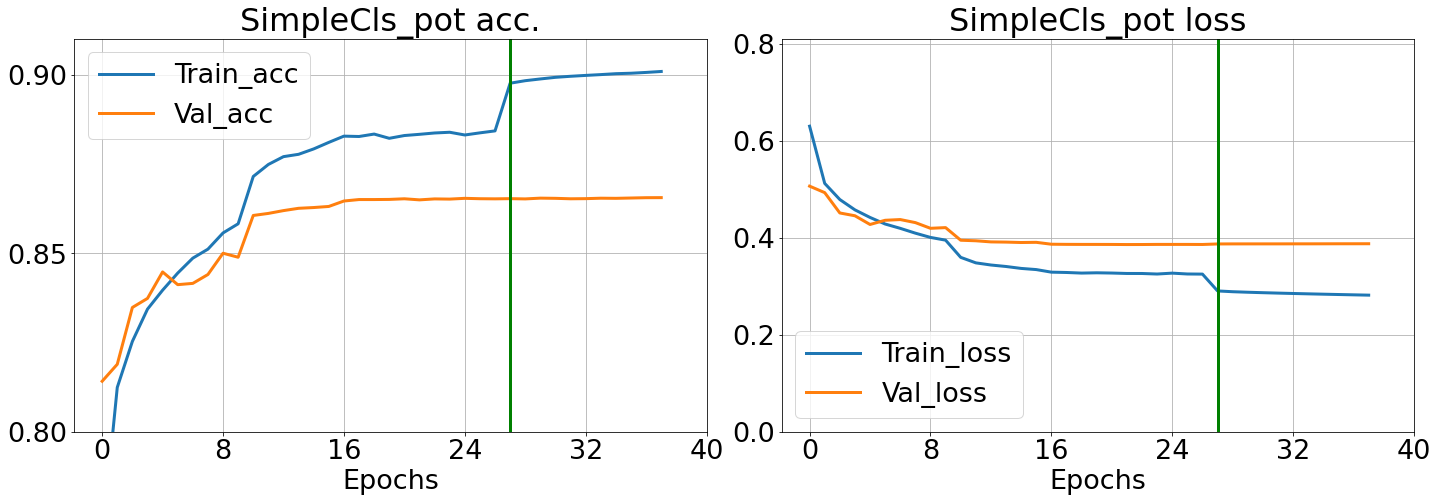

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['accuracy'], *history_unfrozen.history['accuracy']]
history_valacc = [*history_frozen.history['val_accuracy'], *history_unfrozen.history['val_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.91)
plt.xticks(np.linspace(0, 40, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.90, 3), fontsize = ticks_size)
plt.title(model_name + '_pot acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, 40, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.91
Species acc: 0.8655


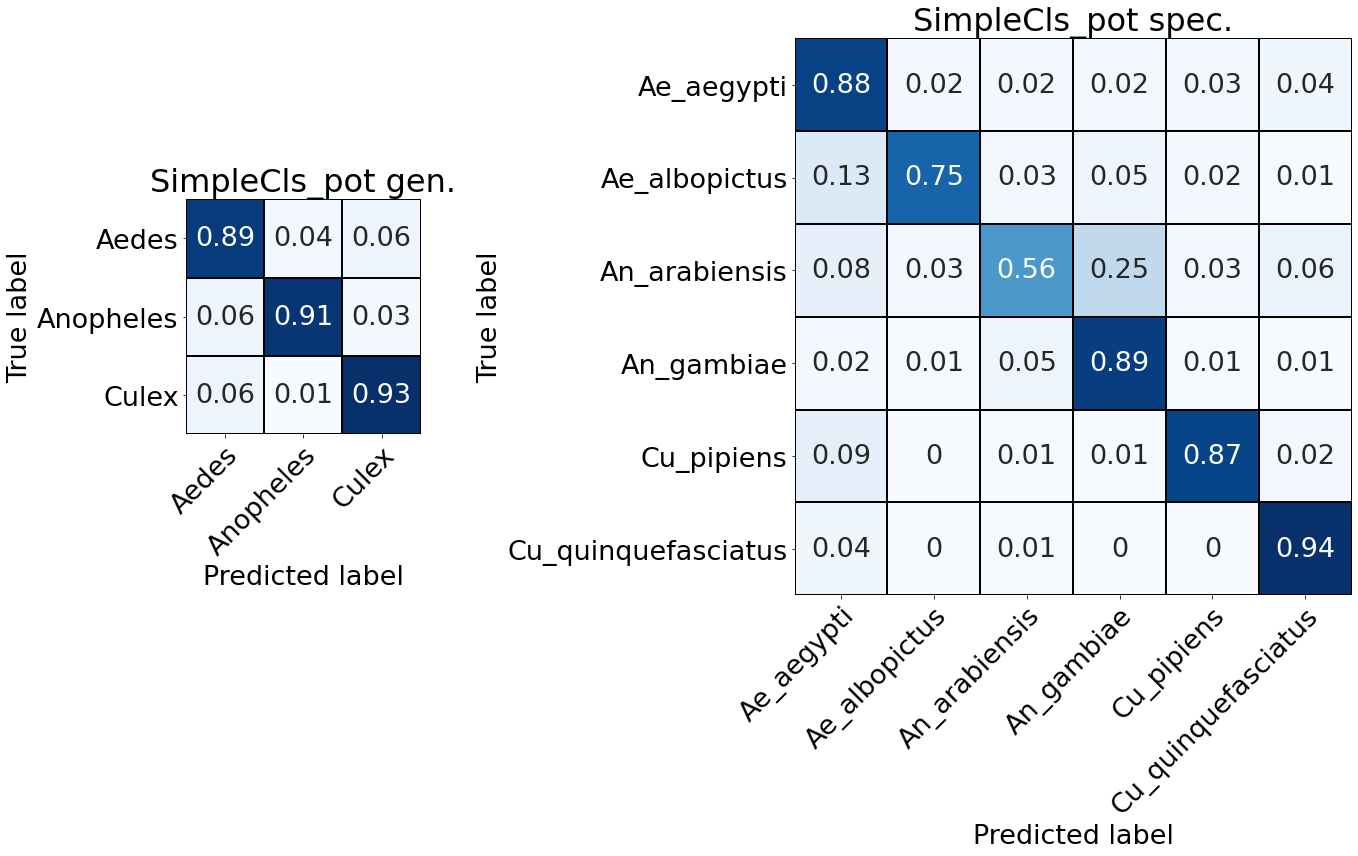

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### SimpleEmbCls

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


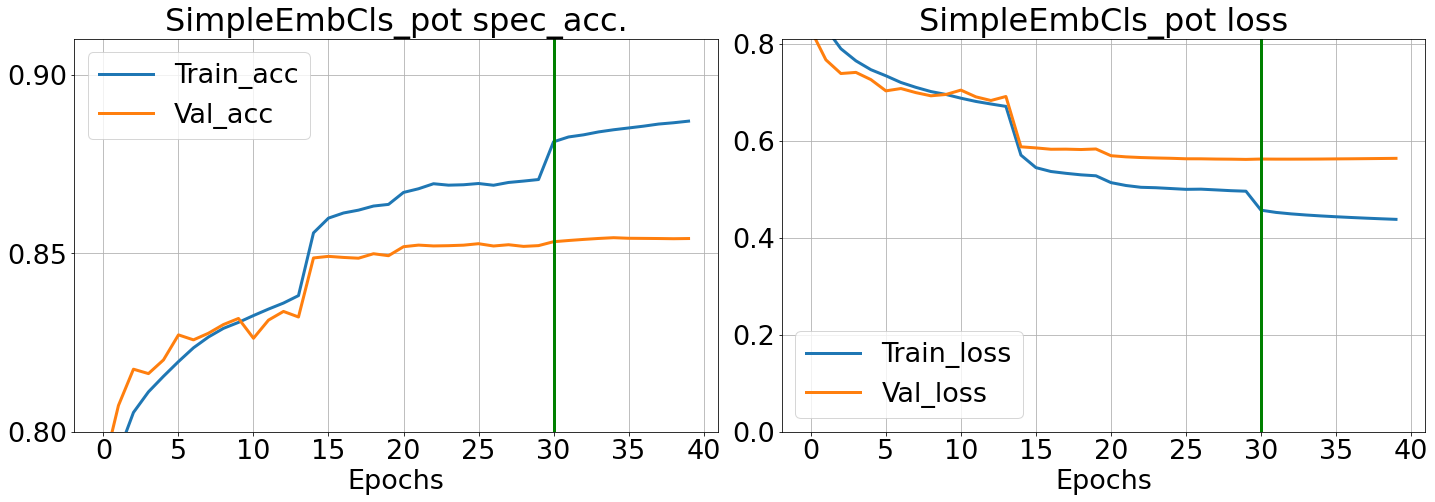

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.91)
plt.xticks(np.linspace(0, epochs+10, 9), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.90, 3), fontsize = ticks_size)
plt.title(model_name + '_pot spec_acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs+10, 9), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9006
Species acc: 0.8541


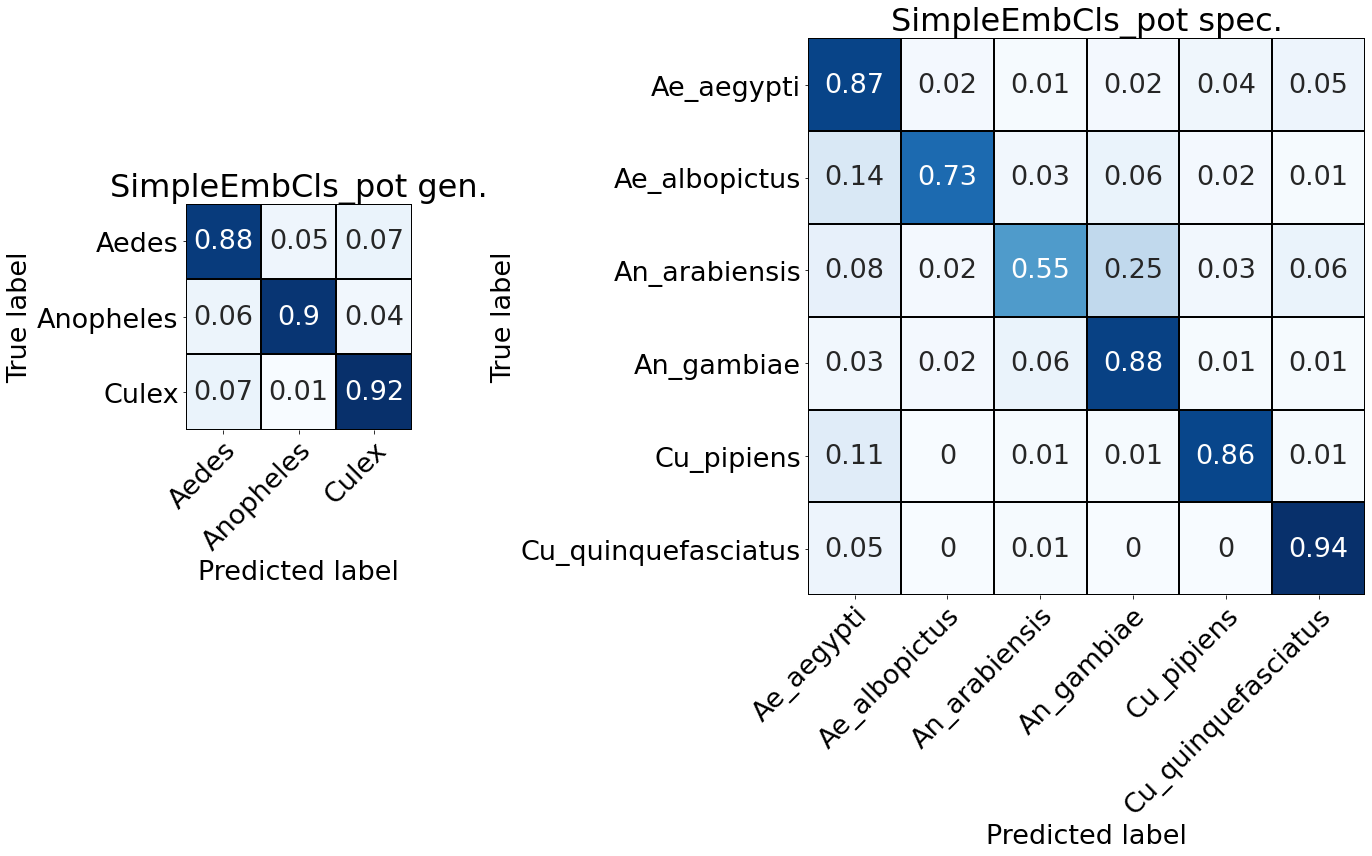

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### HieraCls

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


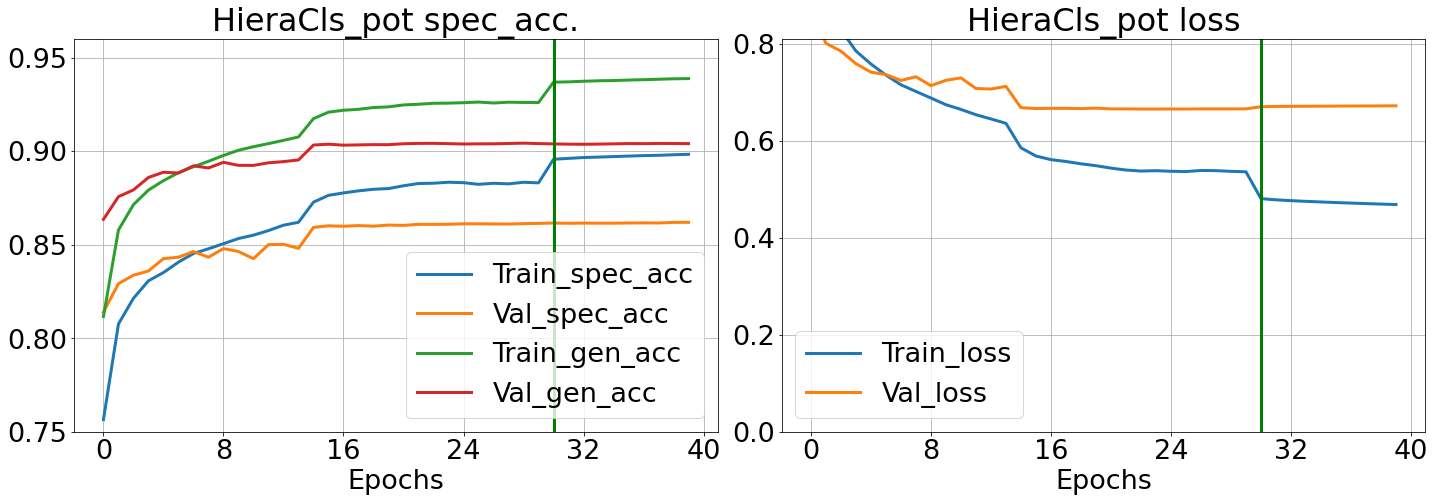

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.75, 0.96)
plt.xticks(np.linspace(0, 40, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.75, 0.95, 5), fontsize = ticks_size)
plt.title(model_name + '_pot spec_acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, 40, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.904
Species acc: 0.8619


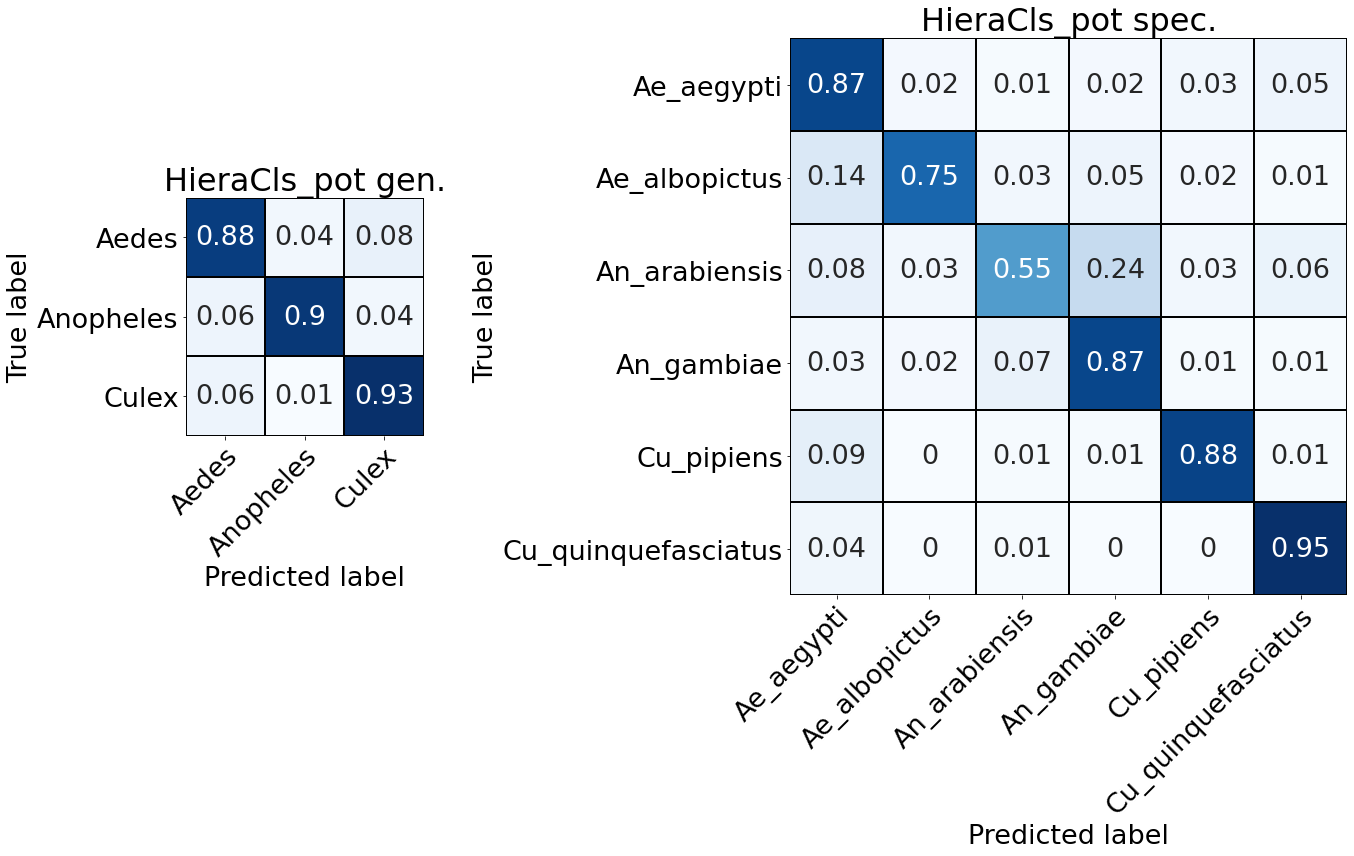

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### HieraEmbCls

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


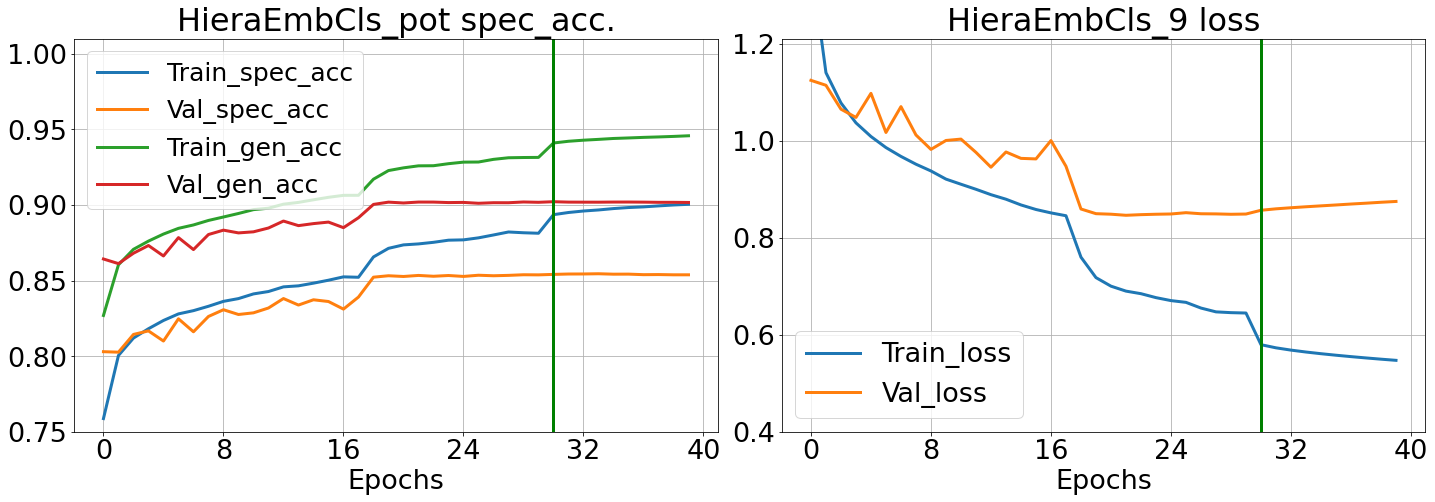

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.75, 1.01)
plt.xticks(np.linspace(0, epochs+10, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.75, 1.0, 6), fontsize = ticks_size)
plt.title(model_name + '_pot spec_acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size-2)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.4, 1.21)
plt.xticks(np.linspace(0, epochs+10, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.4, 1.2, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9017
Species acc: 0.8539


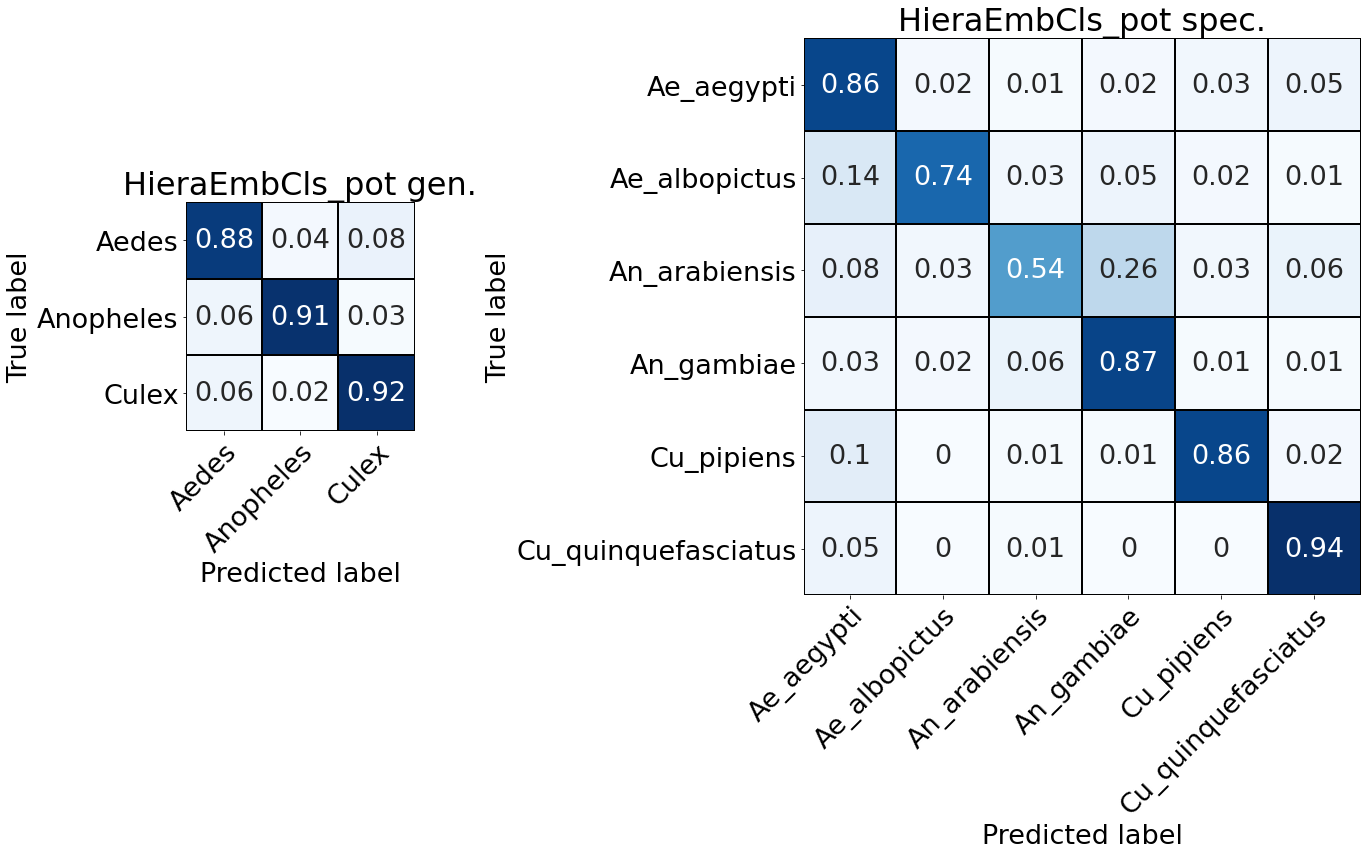

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

## Spectro

### SimpleCls

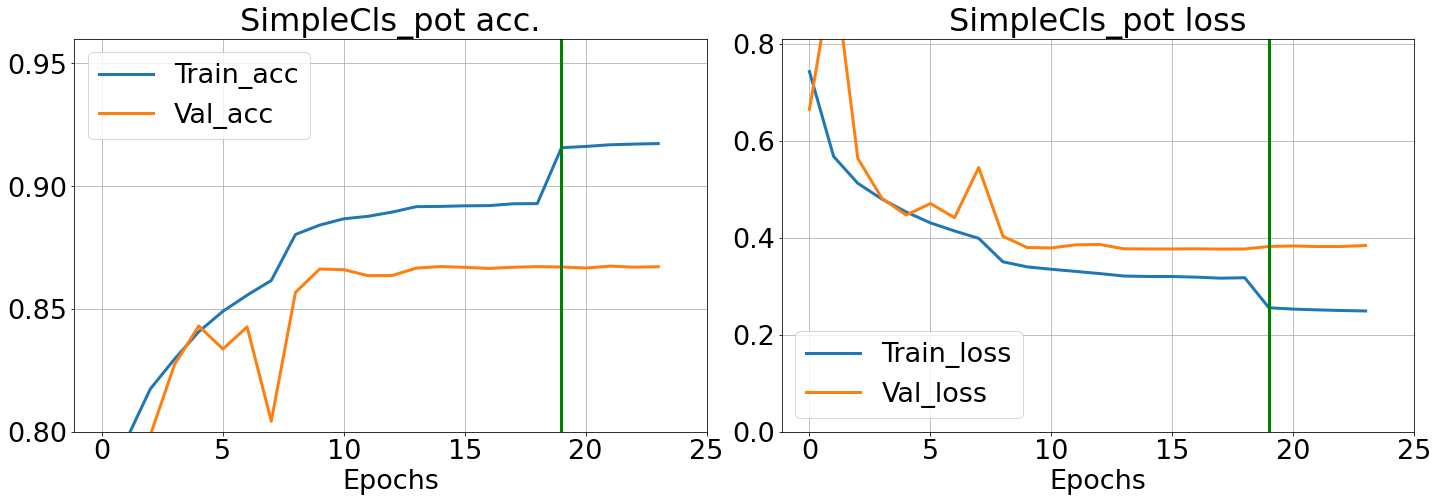

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['accuracy'], *history_unfrozen.history['accuracy']]
history_valacc = [*history_frozen.history['val_accuracy'], *history_unfrozen.history['val_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, 25, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_pot acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, 25, 6), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9155
Species acc: 0.8672


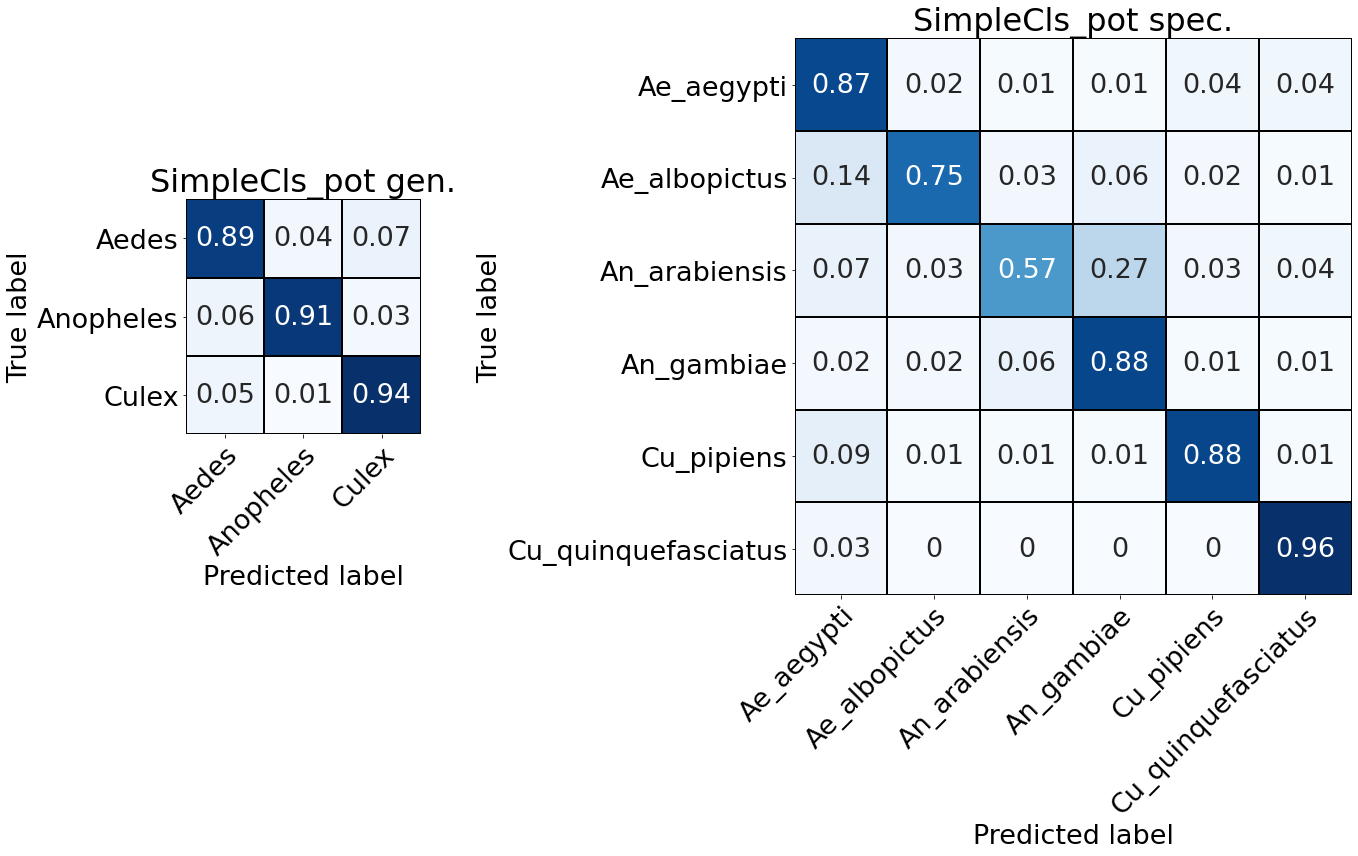

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### SimpleEmbCls

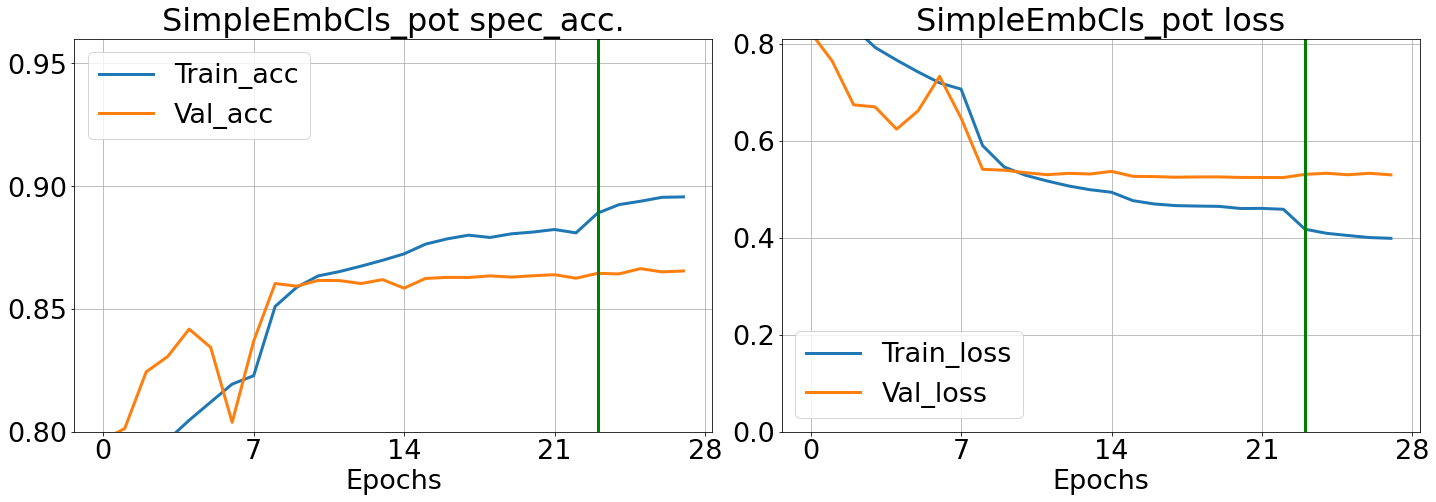

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, stop_ep+5, 5), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_pot spec_acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, stop_ep+5, 5), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9174
Species acc: 0.8656


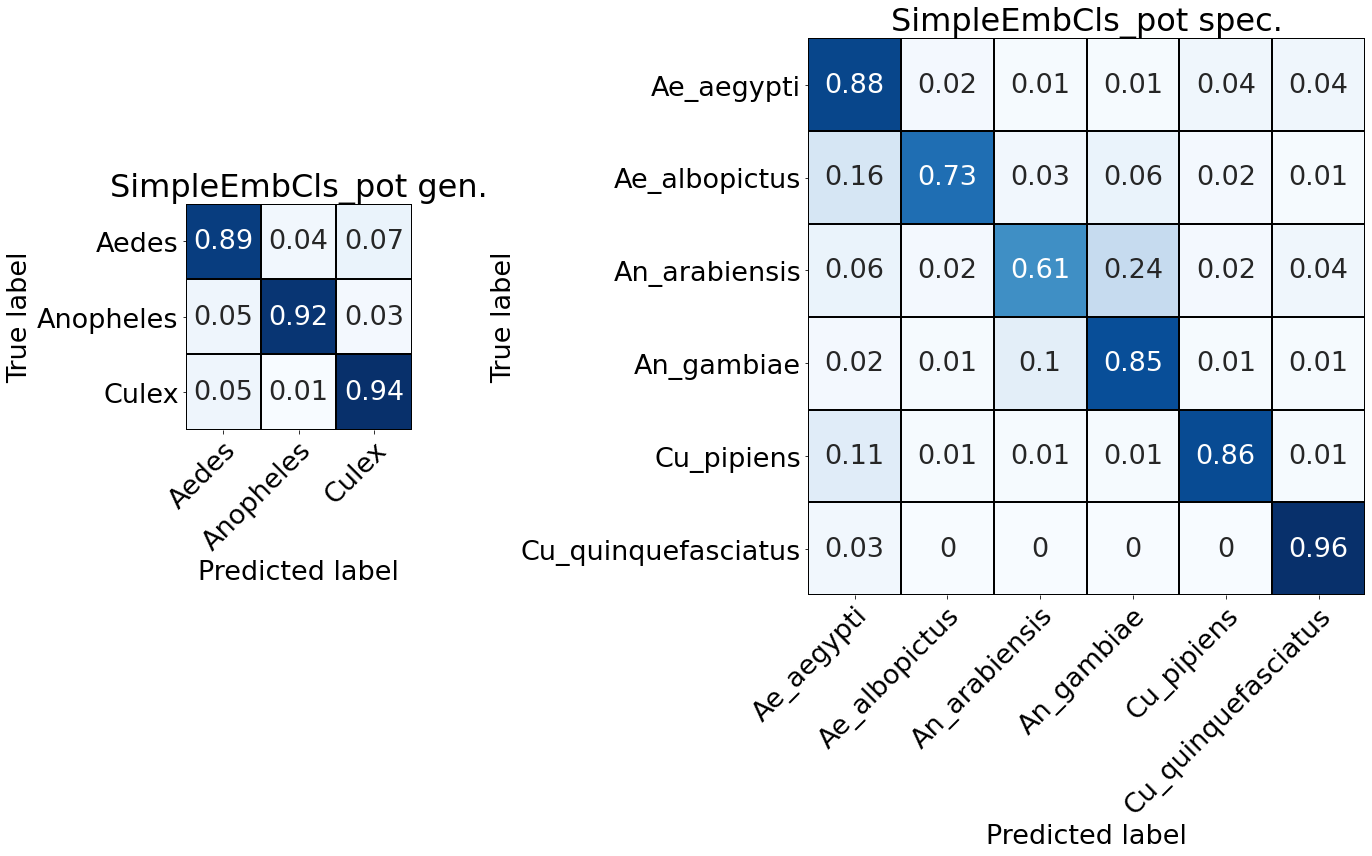

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### HieraCls

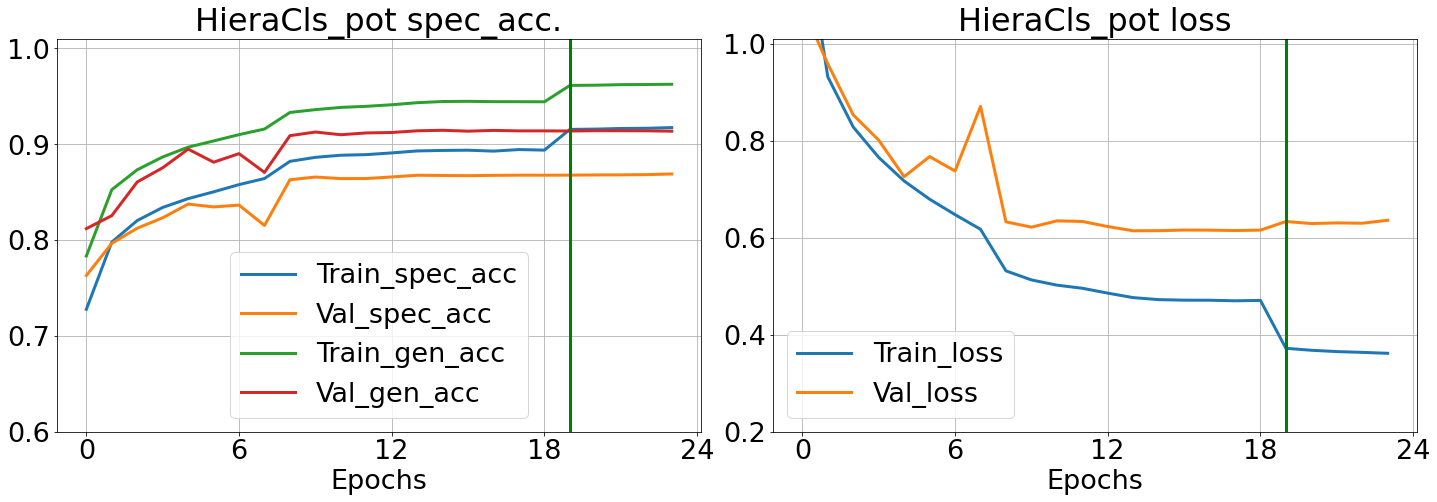

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.6, 1.01)
plt.xticks(np.linspace(0, 24, 5), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.6, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + '_pot spec_acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.2, 1.01)
plt.xticks(np.linspace(0, 24, 5), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.2, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9136
Species acc: 0.869


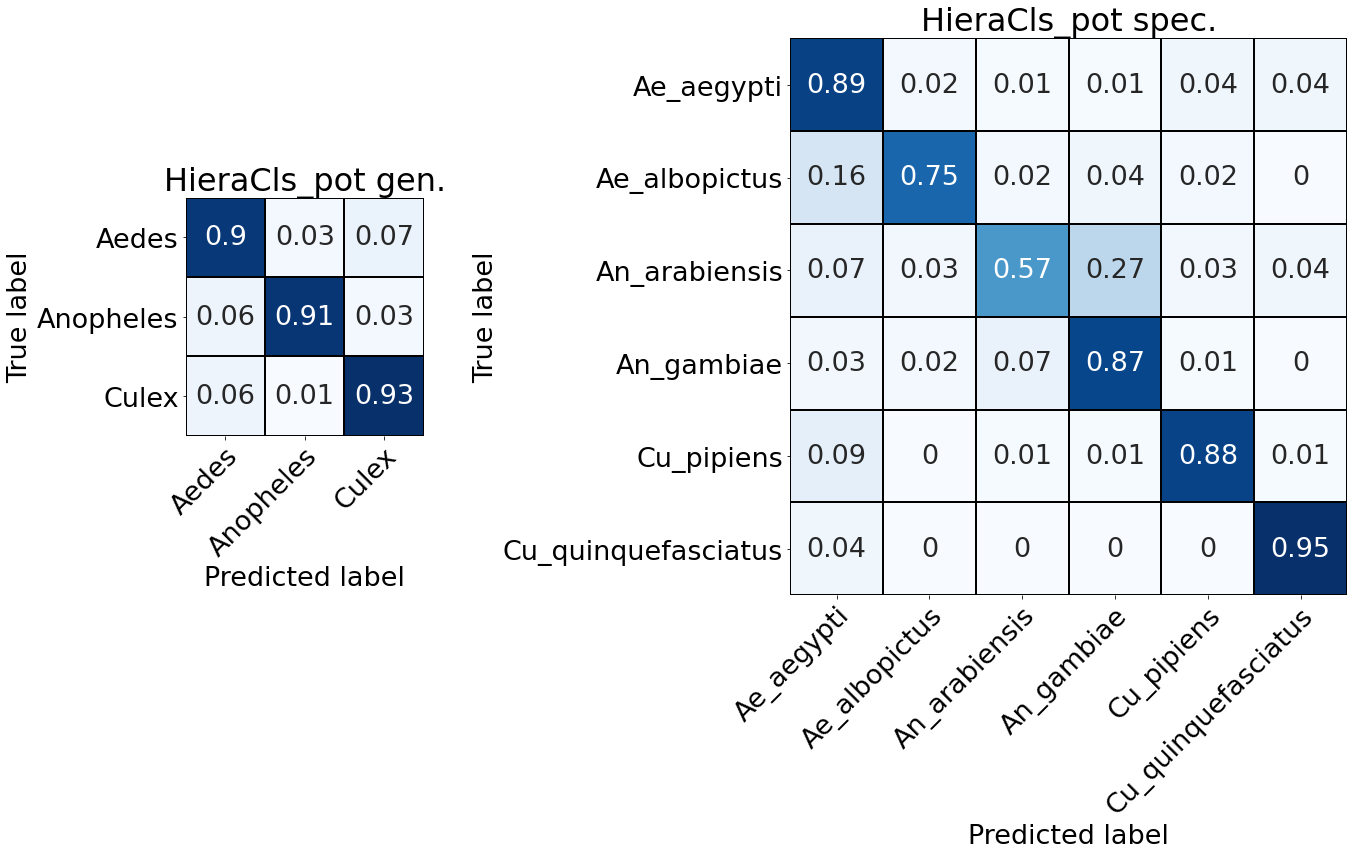

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### HieraEmbCls

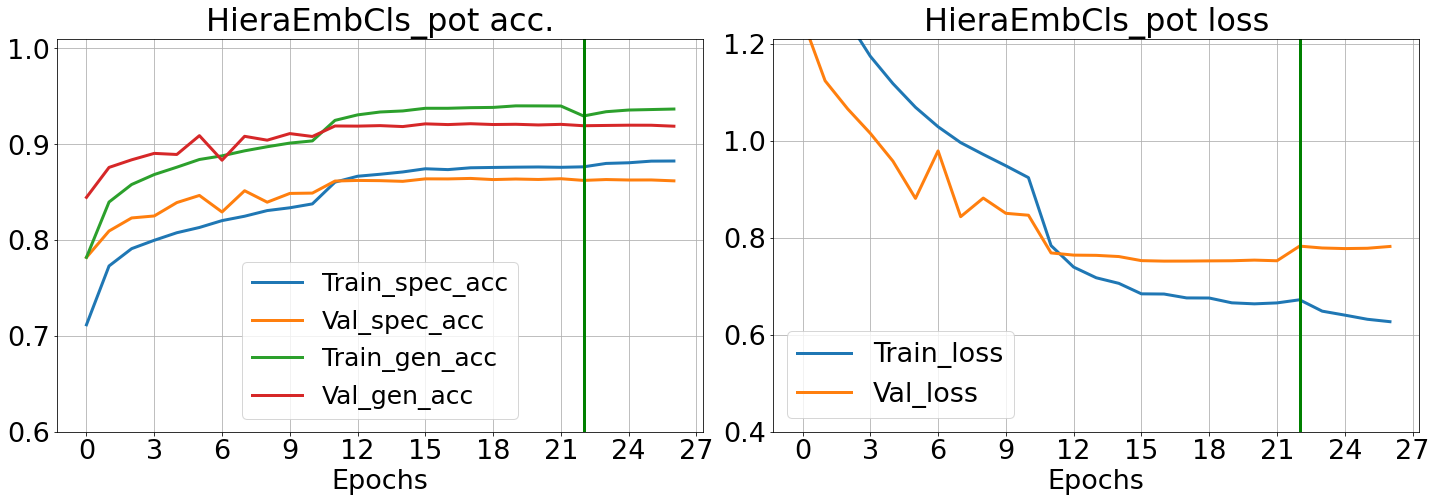

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.6, 1.01)
plt.xticks(np.linspace(0, 27, 10), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.6, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + '_pot acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size-2)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.4, 1.21)
plt.xticks(np.linspace(0, 27, 10), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.4, 1.2, 5), fontsize = ticks_size)
plt.title(model_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + model_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9179
Species acc: 0.8619


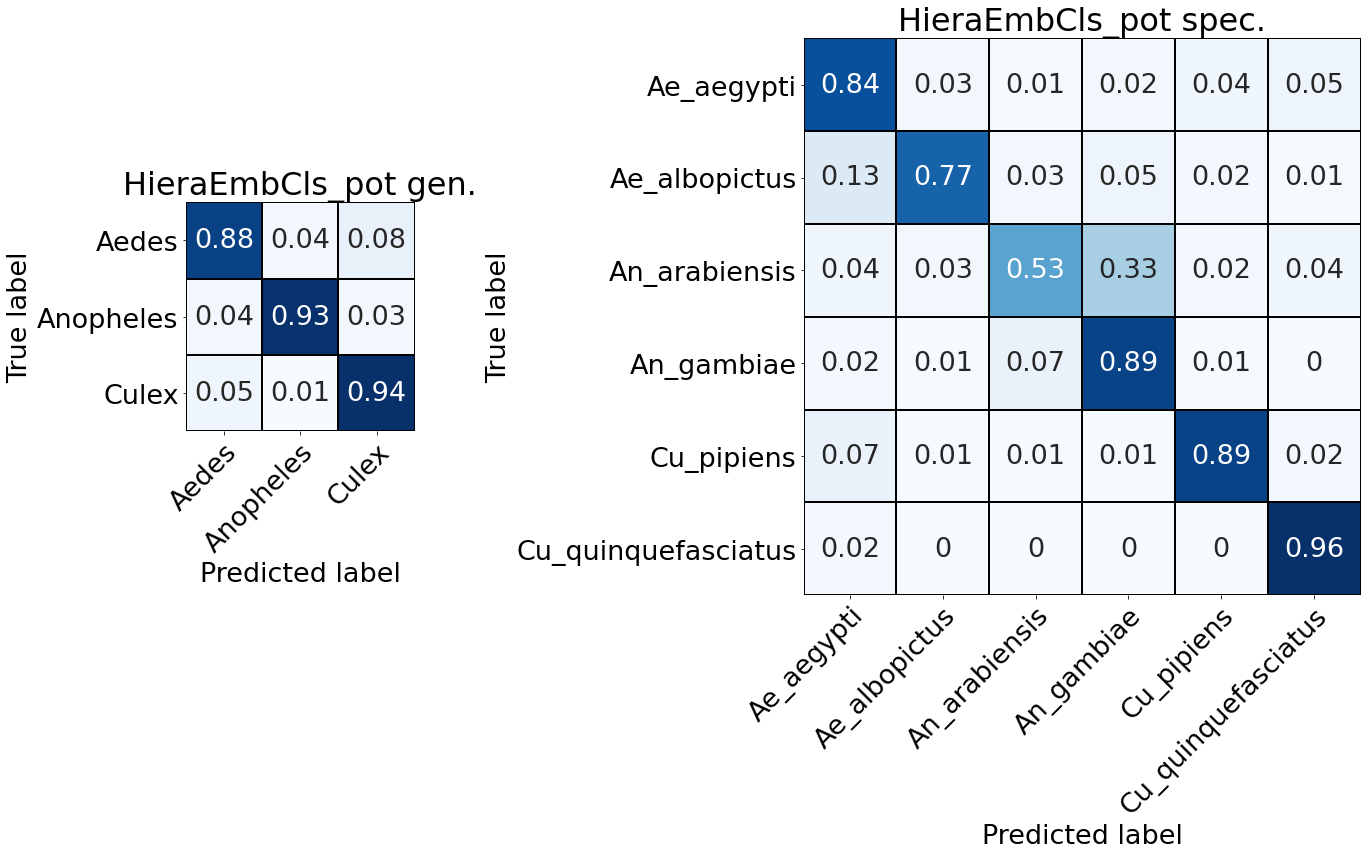

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + model_name + '_pot_trans_conf.eps', bbox_inches = 'tight')

### MobileNet

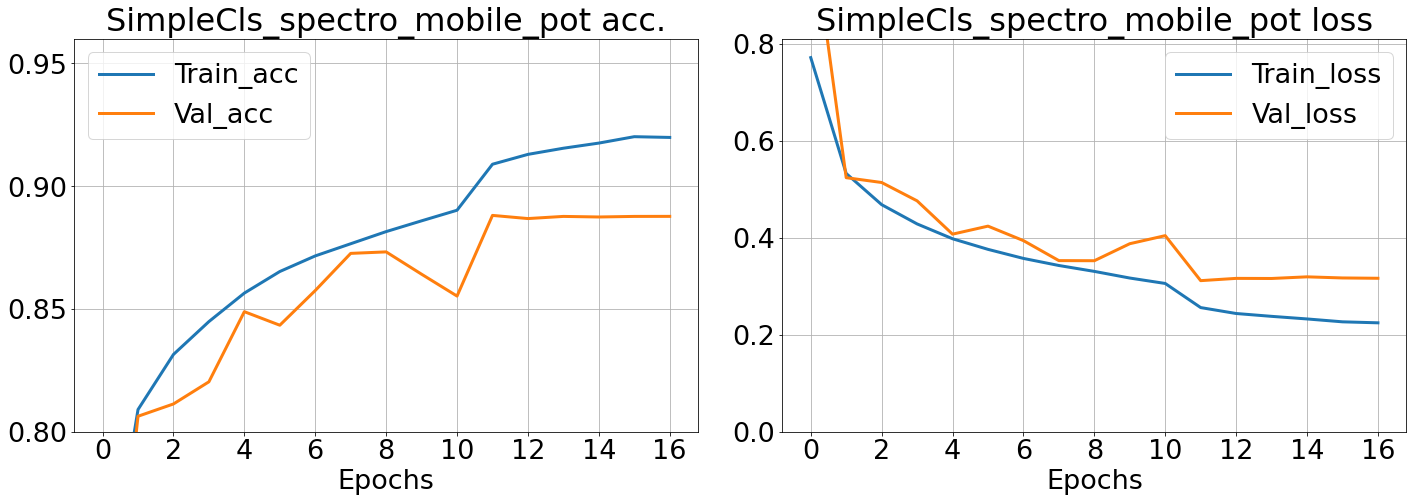

In [ ]:
# Plot histories
history_acc    = history_frozen.history['accuracy']
history_valacc = history_frozen.history['val_accuracy']
history_los    = history_frozen.history['loss']
history_valoss = history_frozen.history['val_loss']

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(full_name + '_pot acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(full_name + '_pot loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(histories_dir + full_name + '_pot_trans_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9324
Species acc: 0.8876


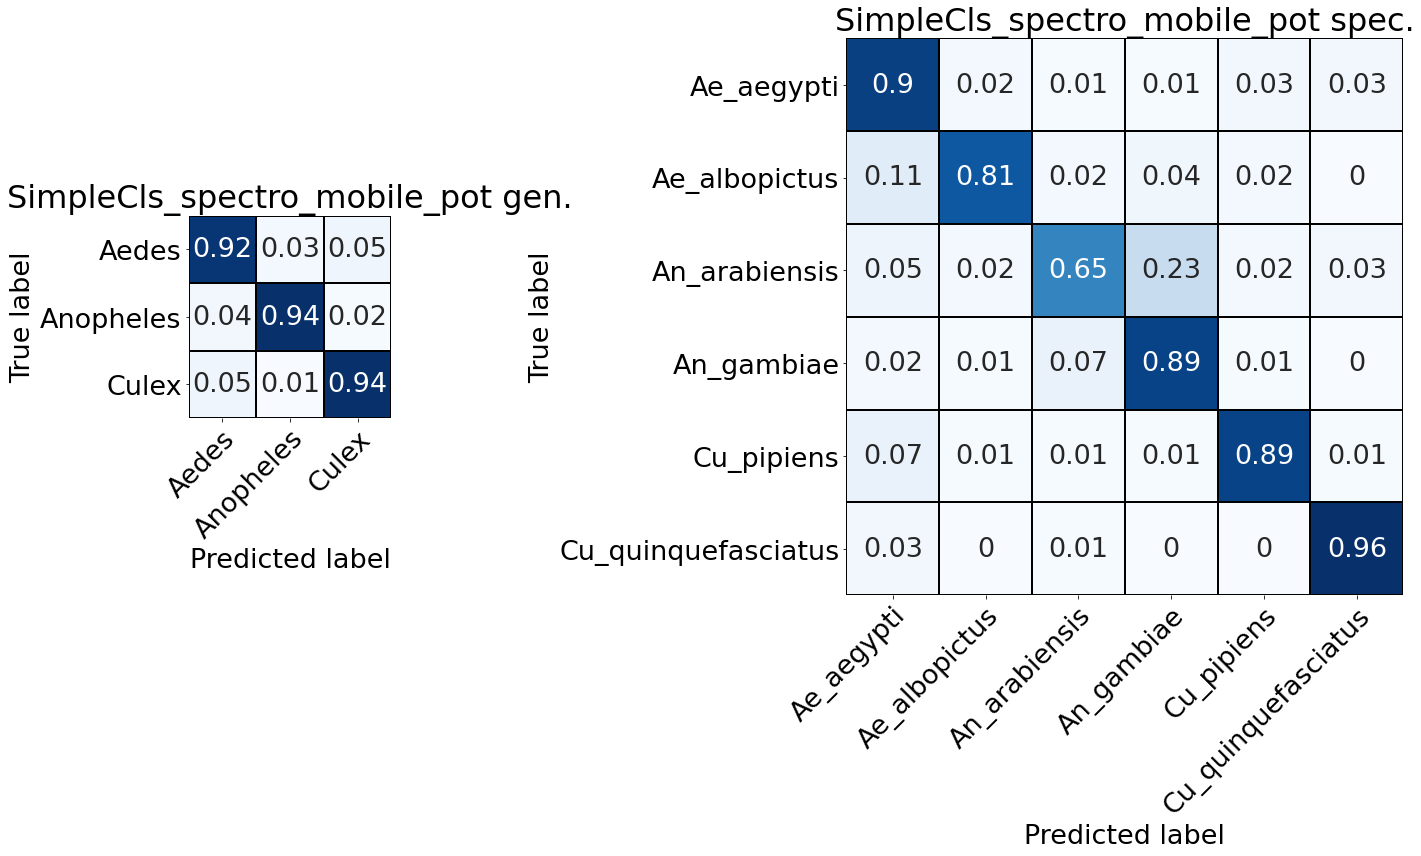

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = full_name + '_pot gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = full_name + '_pot spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(histories_dir + full_name + '_pot_trans_conf.eps', bbox_inches = 'tight')